#### Carga de librerías

In [1]:
from imutils import paths
from imutils import build_montages
from sklearn.cluster import DBSCAN
from random import seed
from random import randint
import numpy as np
import face_recognition
import argparse
import pickle
import cv2
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

In [2]:
#Listar las imagenes a las que queremos extraer un vector
imagePaths = list(paths.list_images('dataset'))

#### Se muestran algunas imágenes aleatoriamente

Number of pictures [60, 33, 94, 121, 16]


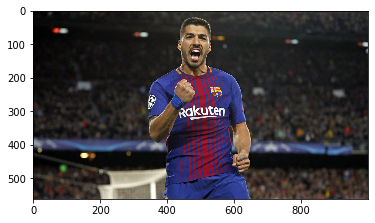

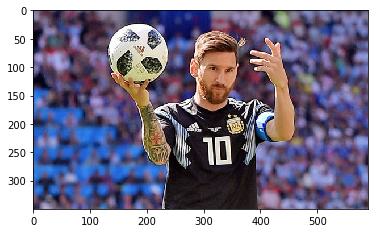

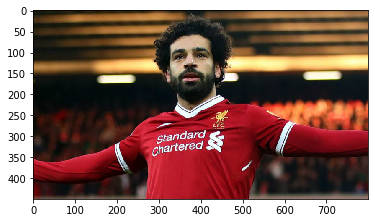

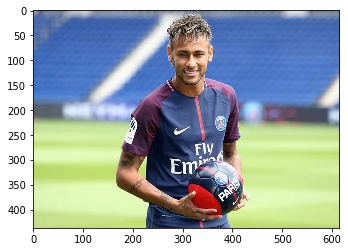

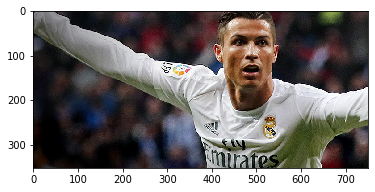

In [3]:
img_list = []
seed(3)
for _ in range(5):
    value = randint(0, len(imagePaths))
    img_list.append(value)
print('Number of pictures {}'.format(img_list))
for i in img_list:
    img=mpimg.imread(imagePaths[i])
    imgplot = plt.imshow(img)
    plt.show()

#### 2.1
Use la librería **face_recognition**, detecte las caras en cada imagen y genere un vector de características para cada cara. Entregue un archivo que describa el nombre de la imagen, la localización de la cara y el vector de características.

In [4]:
data = []
for (i, imagePath) in enumerate(imagePaths):
#    print("Procesando imagen {}/{}".format(i + 1,len(imagePaths)))
    image = cv2.imread(imagePath)
    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    #Detectando las caras
    boxes = face_recognition.face_locations(rgb)
    #boxes = face_recognition.batch_face_locations(rgb,batch_size = 64)
    #Creando los vectores
    encodings = face_recognition.face_encodings(rgb, boxes)
    # Construyendo un diccionario con en el nombre de la imagen, el lugar donde esta la cara y el vector de caracteristicas
    d = [{"imagePath": imagePath, "loc": box, "encoding": enc}
        for (box, enc) in zip(boxes, encodings)]
    data.extend(d)

#Pickle dump
f = open('encodings', "wb")
f.write(pickle.dumps(data))
f.close()
with open('face_recognition.txt', 'w') as f:
    for item in data:
        f.write("%s\n" % item)
f.close()

#### 2.2

Utilice los vectores de características para agrupar las caras de los futbolistas utilizando el algoritmo DBSCAN. Cada grupo corresponderá a un futbolista . Si usted conoce a los futbolistas pueden reemplazar los típicos IDS generados (0, 1, 2, 3 …) por sus nombres.

In [5]:


data_encode = pickle.loads(open('encodings', "rb").read())
data_encode = np.array(data_encode)
encodings = [d["encoding"] for d in data_encode]
clt = DBSCAN(eps=0.5, metric="euclidean", n_jobs=4)
#clt.fit(encodings)
pred = clt.fit_predict(encodings)

In [6]:
print(pred)

[ 0 -1  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1
  1 -1  1  1 -1  1  1  1  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4]


Cluster Unkwnown


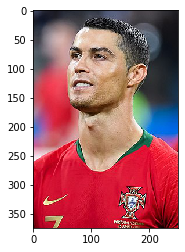

Cluster 0


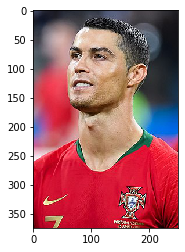

Cluster 1


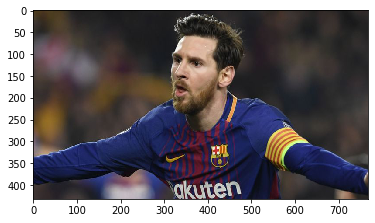

Cluster 2


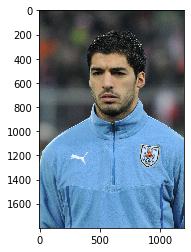

Cluster 3


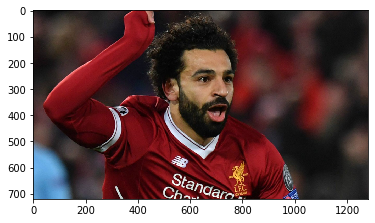

Cluster 4


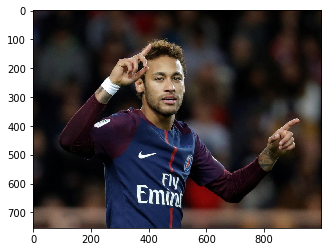

In [7]:
data_proc = data_encode.copy()
cluster_img = {str(x):[] for x in clt.labels_}
for i in range(len(pred)):
    data_proc[i].update({'Cluster':str(pred[i])})
    cluster_img[str(pred[i])].append(data_proc[i]['imagePath']) 
    
for l in np.unique(clt.labels_):
    if str(l) == '-1':
        print('Cluster Unkwnown')
    else:
        print('Cluster {}'.format(str(l)))
    img=mpimg.imread(cluster_img[str(l)][0])
    imgplot = plt.imshow(img)
    plt.show()


In [8]:
img_face_name = {'-1':'Unkwnown'
                 ,'0':'Cristiano Ronaldo'
                ,'1':'Lionel Messi'
                ,'2':'Luis Suarez'
                ,'3':'Mohamed Salah'
                ,'4':'Neymar'}
pred_new = []
for i in pred:
    pred_new.append(img_face_name[str(i)])
    #data_proc[i].update({'Cluster_New':img_face_name[str(i)]})
for i in range(len(pred)):
    data_proc[i].update({'Cluster_New':str(pred_new[i])})

#### 2.3
Indique cuántos futbolistas distintos (número de clústeres) hay en el data set.

In [9]:
unknown = [-1]
tot_labels = np.unique(clt.labels_)
tot_faces = list(set(tot_labels) - set(unknown))

print('Se detectaron {} distintas caras en las imagenes procesadas'.format(len(tot_faces)))

Se detectaron 5 distintas caras en las imagenes procesadas


#### 2.4
Genere una forma de visualizar los clústeres. Para esto extraiga cada cara de cada imagen y despliéguela en grupo. Despliegue hasta un máximo de 9 caras por grupo, ignore el resto. Cambie el tamaño de las imágenes para visualizar inteligentemente. Recuerde que en archivo generado en 2.1 existe esa información.


 Persona identificada: Cristiano Ronaldo



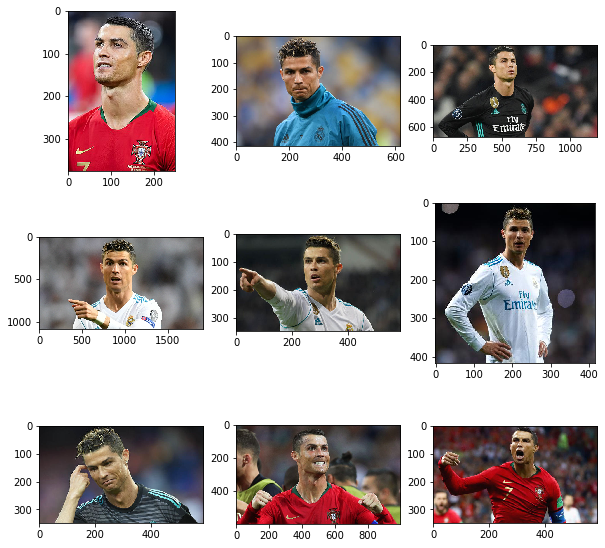


 Persona identificada: Unkwnown



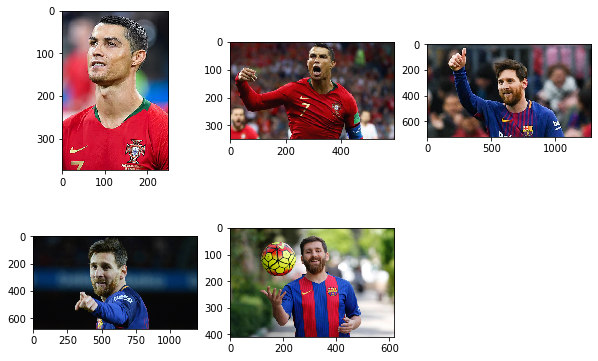


 Persona identificada: Lionel Messi



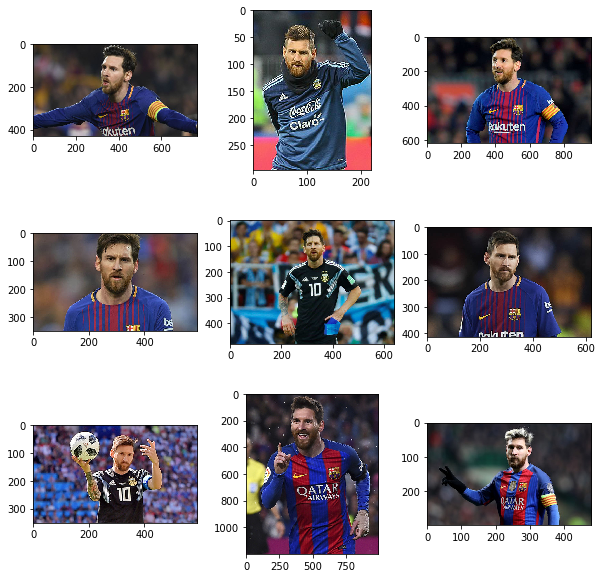


 Persona identificada: Luis Suarez



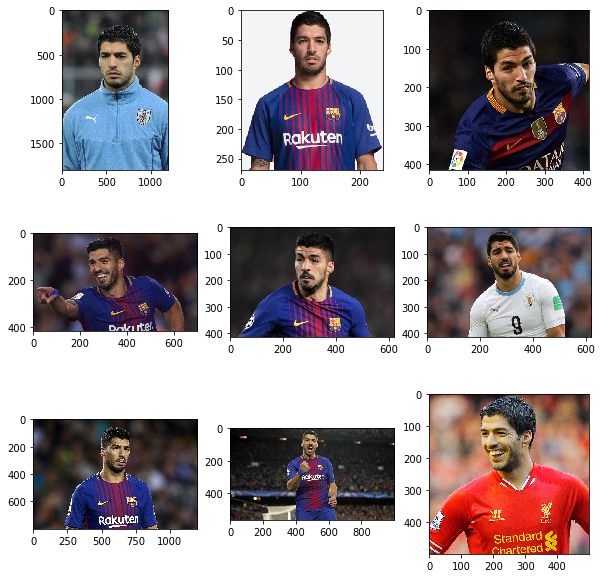


 Persona identificada: Mohamed Salah



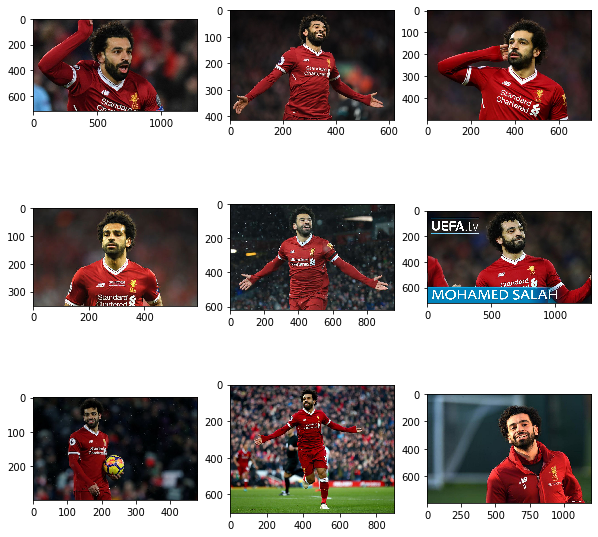


 Persona identificada: Neymar



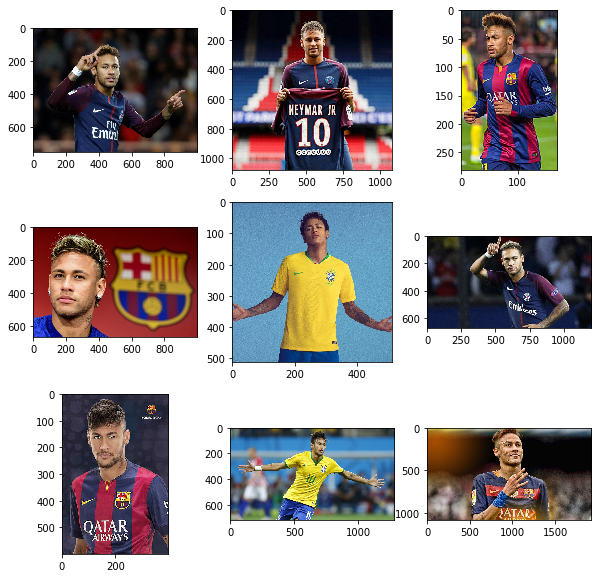

In [10]:


#w=10
#h=10
for k,v in cluster_img.items():
    fig=plt.figure(figsize=(10, 10))
    print('\n Persona identificada: {}\n'.format(img_face_name[str(k)]))
    #print(len(v))
    n_plots = 9
    if len(v) < n_plots:
        n_plots = len(v)
    for i in range(1, n_plots +1):
        img=mpimg.imread(v[i-1])
        #imgplot = plt.imshow(img)
        #plt.show()
        #img = np.random.randint(10, size=(h,w))
        fig.add_subplot(3, 3, i)
        plt.imshow(img)
    plt.show()

#### 2.5
En el set de imágenes hay un futbolista que no podrá ser identificado porque no pertenecerá a ningún clúster (outlier). Despliegue su cara.

**img49**